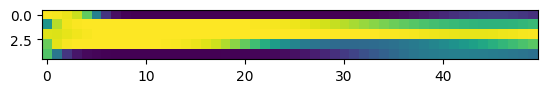

In [36]:
import numpy as np
from scipy.special import expit, logit

class TensorModelWithGenetics:
    def __init__(self, N, P, D, K, R1, R2, T):
        self.N = N  # Number of individuals
        self.P = P  # Number of genetic variants
        self.D = D  # Number of diseases
        self.K = K  # Number of signatures
        self.R1 = R1  # Rank for individual patterns
        self.R2 = R2  # Rank for disease patterns
        self.T = T  # Number of time points
        self.initialized = False
        self.initialize_parameters()

        
    def initialize_parameters(self):
        self.U1 = np.random.randn(self.N, self.K, self.R1) * 0.5  # Increased from 0.01
        self.U2 = create_smooth_basis(self.T, self.R1)
        self.W = np.random.randn(self.D, self.K, self.R2) * 0.5  # Increased from 0.01
        self.U3 = create_smooth_basis(self.T, self.R2)
        self.G = np.random.binomial(2, 0.3, size=(self.N, self.P))
        self.B = np.random.randn(self.P, self.K, self.R1) * 0.05  # Increased from 0.001
        self.C = np.random.randn(self.N, self.K, self.R1) * 0.05  # Increased from 0.001
        self.initialized = True
 
    def get_dimensions(self):
        return {
            'N': self.N,
            'P': self.P,
            'D': self.D,
            'K': self.K,
            'R1': self.R1,
            'R2': self.R2,
            'T': self.T
        }
    def get_parameters(self):
        if not self.initialized:
            raise ValueError("Parameters have not been initialized yet.")
        return {
        'U1': self.U1,
        'U2': self.U2,
        'W': self.W,
        'U3': self.U3,
        'G': self.G,
        'B': self.B,
        'C': self.C
    }
    

    def compute_U1G(self):
        U1G = self.U1.copy()
        genetic_effect = np.einsum('np,pkr->nkr', self.G, self.B)
        U1G += genetic_effect + self.C
        return U1G

    def compute_theta(self):
        U1G = self.compute_U1G()
        lambda_k = np.einsum('nkr,tr->nkt', U1G, self.U2)
        phi = np.einsum('dkr,tr->dkt', self.W, self.U3)
        theta = np.einsum('nkt,dkt->ndt', lambda_k, phi)
        return theta

    def survival_likelihood(self, Y, S):
        theta = self.compute_theta()
        pi = expit(theta)
        log_likelihood = 0
        for n in range(self.N):
            for d in range(self.D):
                t = S[n, d]
                log_likelihood += np.sum(np.log(1 - pi[n, d, :t] + 1e-10))
                if Y[n, d, t] == 1:
                    log_likelihood += np.log(pi[n, d, t] + 1e-10)
                    pi[n, d, t+1:] = 0
        return log_likelihood

    def compute_gradients(self, Y, S):
        theta = self.compute_theta()
        pi = expit(theta)
        U1G = self.compute_U1G()
        lambda_k = np.einsum('nkr,tr->nkt', U1G, self.U2)
        phi = np.einsum('dkr,tr->dkt', self.W, self.U3)
        
        d_theta = np.zeros_like(theta)
        for n in range(self.N):
            for d in range(self.D):
                t = S[n, d]
                d_theta[n, d, :t] = -pi[n, d, :t]
                if Y[n, d, t] == 1:
                    d_theta[n, d, t] += 1
        
        d_lambda = np.einsum('ndt,dkt->nkt', d_theta, phi)
        d_phi = np.einsum('ndt,nkt->dkt', d_theta, lambda_k)
        
        d_U1G = np.einsum('nkt,tr->nkr', d_lambda, self.U2)
        d_W = np.einsum('dkt,tr->dkr', d_phi, self.U3)
        
        d_U1 = d_U1G
        d_B = np.einsum('nkr,np->pkr', d_U1G, self.G)
        d_C = d_U1G
        
        return d_U1, d_W, d_B, d_C

    def fit(self, Y, S, num_iterations=1000, learning_rate=1e-4, l2_reg=1e-5, clip_value=1.0, patience=50):
        losses = []
        best_loss = -np.inf
        patience_counter = 0
        
        for iteration in range(num_iterations):
            log_likelihood = self.survival_likelihood(Y, S)
            loss = log_likelihood - l2_reg * (np.sum(self.U1**2) + np.sum(self.W**2) + np.sum(self.B**2) + np.sum(self.C**2))
            losses.append(loss)
            
            if loss > best_loss:
                best_loss = loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at iteration {iteration}")
                    break
            
            d_U1, d_W, d_B, d_C = self.compute_gradients(Y, S)
            
            d_U1 = np.clip(d_U1, -clip_value, clip_value)
            d_W = np.clip(d_W, -clip_value, clip_value)
            d_B = np.clip(d_B, -clip_value, clip_value)
            d_C = np.clip(d_C, -clip_value, clip_value)
            
            self.U1 += learning_rate * (d_U1 - 2 * l2_reg * self.U1)
            self.W += learning_rate * (d_W - 2 * l2_reg * self.W)
            self.B += learning_rate * (d_B - 2 * l2_reg * self.B)
            self.C += learning_rate * (d_C - 2 * l2_reg * self.C)
            
            if iteration % 10 == 0:
                print(f"Iteration {iteration}, Log-likelihood: {log_likelihood}")
        
        return losses
    

# Set random seed for reproducibility
np.random.seed(42)

def create_smooth_basis(T, R):
    t = np.linspace(0, 1, T)
    basis = np.zeros((T, R))
    basis[:, 0] = 4 * (1 - t)**3  # early peaking
    basis[:, 1] = 27 * t * (1 - t)**2  # middle peaking
    basis[:, 2] = 4 * t**3  # late peaking
    return basis

# Set up model parameters
N, P, D, K, R1, R2, T = 1000, 20, 5, 3, 3, 3, 50

# Generate synthetic data
true_model = TensorModelWithGenetics(N, P, D, K, R1, R2, T)
true_model.initialize_parameters()

theta_true = true_model.compute_theta()
pi_true = expit(theta_true)
pi_true
plt.imshow(pi_true[0])

In [39]:

Y = np.zeros((N, D, T), dtype=int)
S = np.full((N, D), T - 1)

for n in range(N):
    for d in range(D):
        event_times = np.random.choice(T, size=1, p=pi_true[n, d, :] / np.sum(pi_true[n, d, :]))
        if event_times[0] < T - 1:
            Y[n, d, event_times[0]] = 1
            S[n, d] = event_times[0]

# Initialize and fit the model
model_fit = TensorModelWithGenetics(N, P, D, K, R1, R2, T)
model_fit.initialize_parameters()
losses = model_fit.fit(Y, S, num_iterations=500, learning_rate=1e-3, l2_reg=1e-5)


theta_fit = model_fit.compute_theta()
pi_fit = expit(theta_fit)
pi_fit


Iteration 0, Log-likelihood: -336343.35029494716
Iteration 10, Log-likelihood: -261747.99570516837
Iteration 20, Log-likelihood: -210445.41605346542
Iteration 30, Log-likelihood: -174674.88157563735
Iteration 40, Log-likelihood: -147984.8381183358
Iteration 50, Log-likelihood: -125669.04832542704
Iteration 60, Log-likelihood: -106619.2943450107
Iteration 70, Log-likelihood: -90725.72322807887
Iteration 80, Log-likelihood: -78046.99947985569
Iteration 90, Log-likelihood: -68425.80515953865
Iteration 100, Log-likelihood: -61275.90732907617
Iteration 110, Log-likelihood: -55720.73360221497
Iteration 120, Log-likelihood: -50990.8339562709
Iteration 130, Log-likelihood: -46840.79588317724
Iteration 140, Log-likelihood: -43169.54323324891
Iteration 150, Log-likelihood: -39876.96185742303
Iteration 160, Log-likelihood: -36953.79864695009
Iteration 170, Log-likelihood: -34346.85117937912
Iteration 180, Log-likelihood: -32022.918315029823
Iteration 190, Log-likelihood: -29943.13498915231
Iterat

array([[[3.92660102e-05, 1.30909921e-03, 2.56365154e-02, ...,
         6.27376643e-01, 6.56160055e-01, 6.79434793e-01],
        [3.74137049e-03, 1.41067269e-03, 7.40571290e-04, ...,
         8.45562971e-01, 8.85194371e-01, 9.13098576e-01],
        [1.55754198e-03, 5.00230598e-03, 1.04769640e-02, ...,
         1.46617170e-03, 5.86446924e-04, 2.16959139e-04],
        [4.33215206e-05, 5.90319297e-06, 1.57114424e-06, ...,
         8.63992226e-01, 9.09015360e-01, 9.35697339e-01],
        [1.72535170e-03, 5.46808855e-04, 2.21575327e-04, ...,
         4.51689306e-01, 4.92540712e-01, 5.08453040e-01]],

       [[7.30521862e-03, 8.83508961e-03, 1.05618555e-02, ...,
         9.05437735e-01, 9.28990580e-01, 9.48480171e-01],
        [8.90052077e-02, 5.56715336e-02, 3.83789153e-02, ...,
         9.93140278e-01, 9.96615540e-01, 9.98418986e-01],
        [1.47973611e-04, 4.24129345e-04, 1.07751998e-03, ...,
         9.89235377e-01, 9.94504957e-01, 9.97288001e-01],
        [2.45872641e-01, 1.21100834e-0

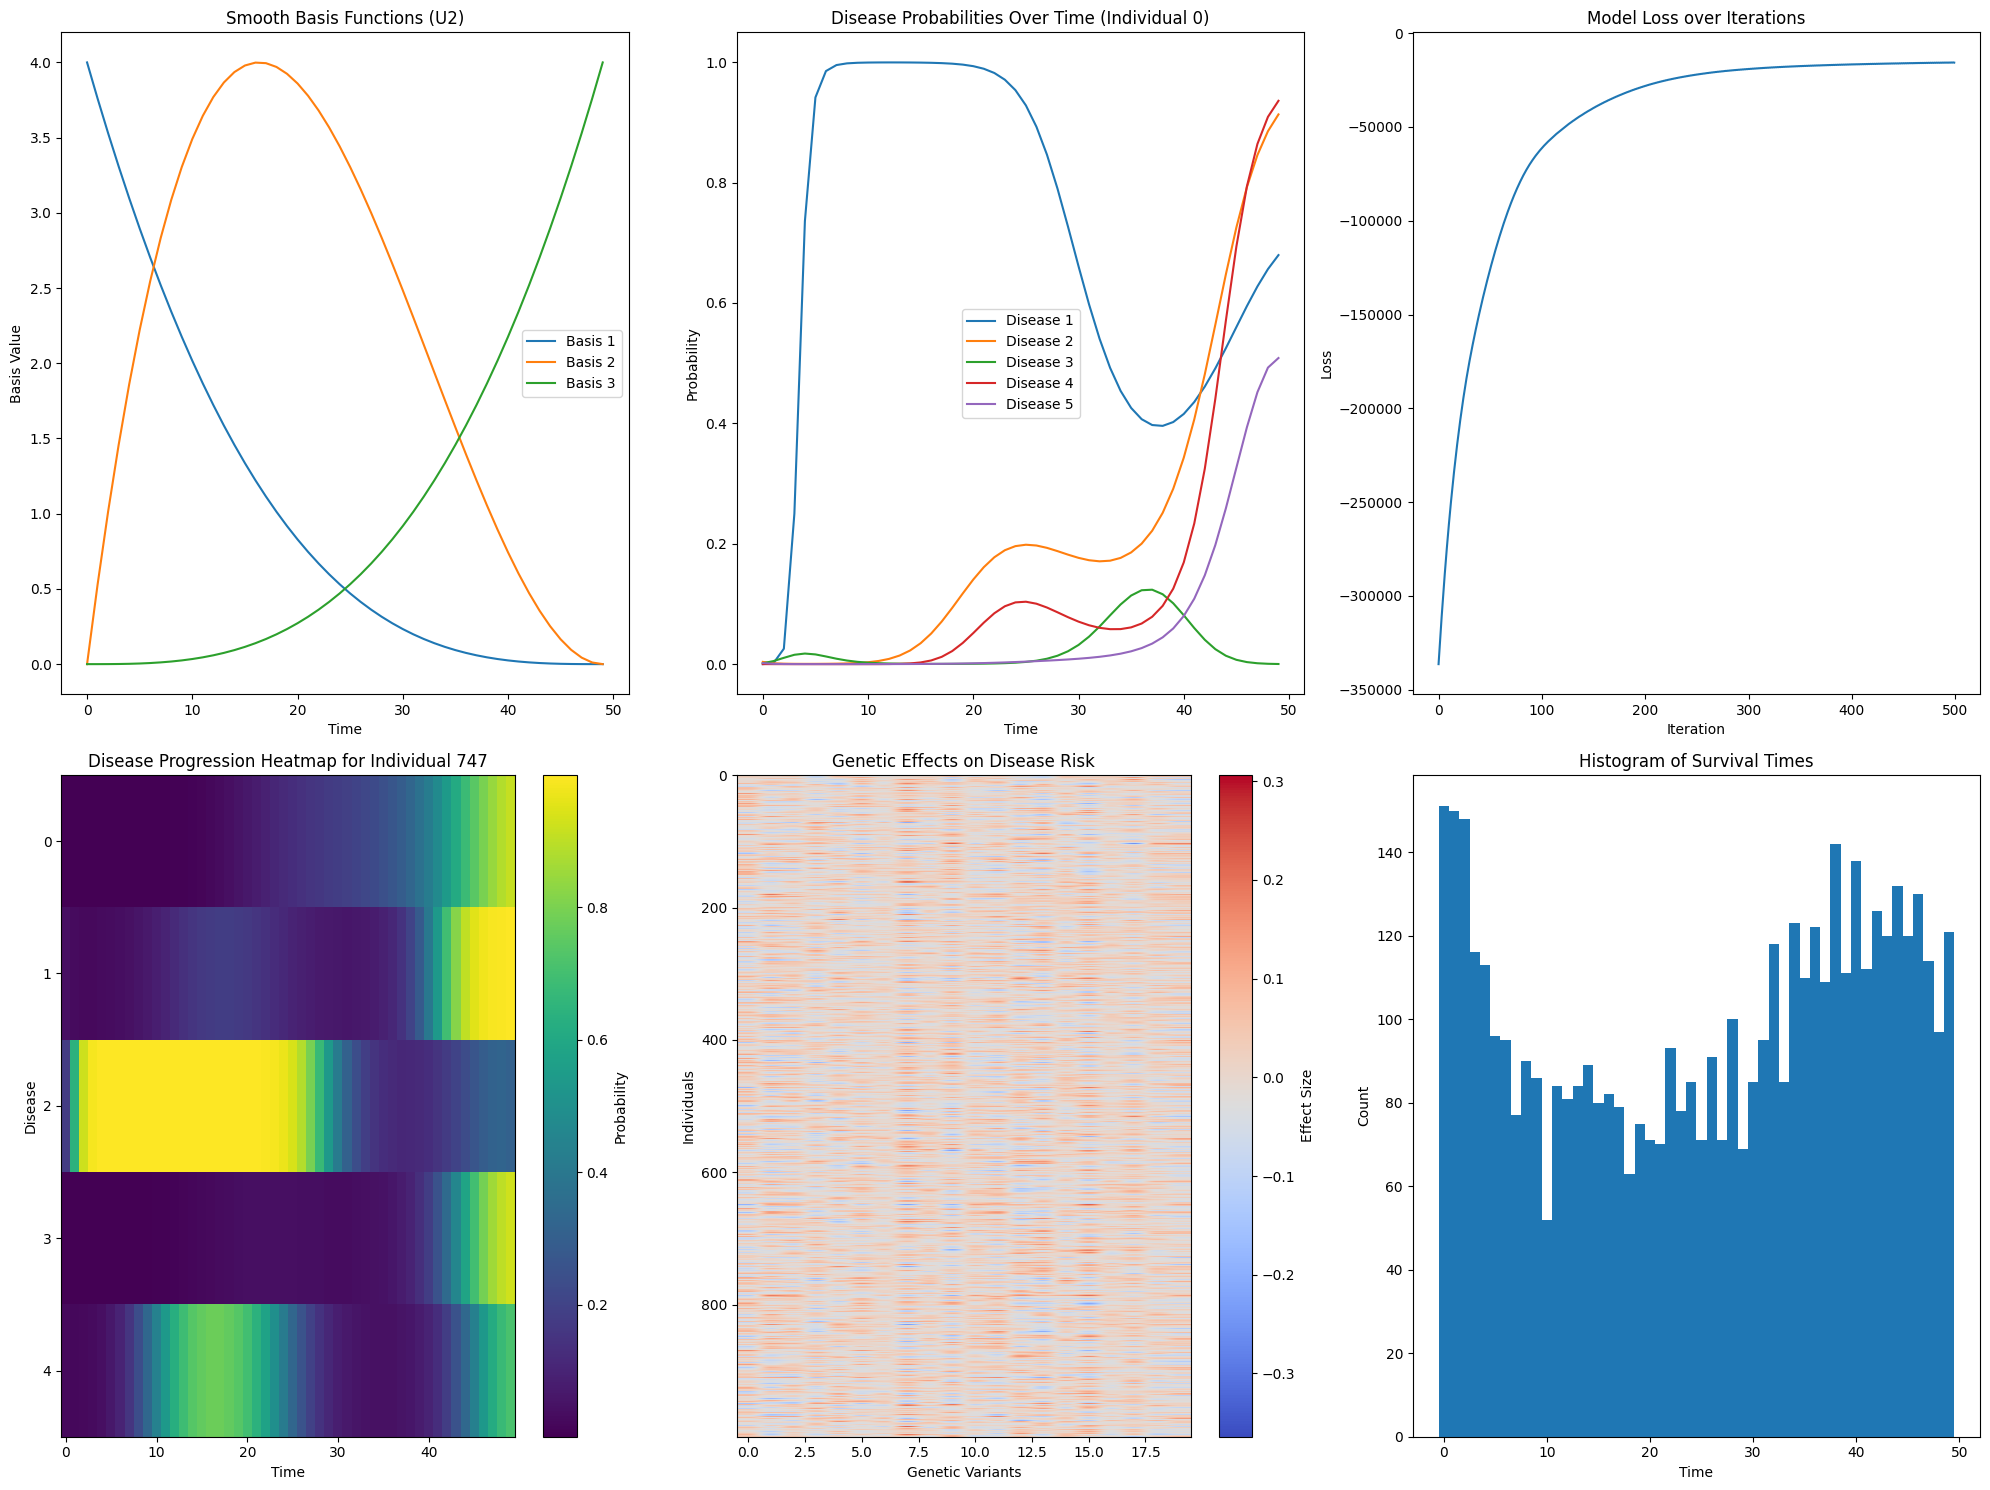

Mean survival time: 25.42
Median survival time: 27.00


In [40]:
# Plotting
plt.figure(figsize=(20, 15))

# Plot smooth basis functions
plt.subplot(2, 3, 1)
for r in range(R1):
    plt.plot(true_model.U2[:, r], label=f'Basis {r+1}')
plt.title('Smooth Basis Functions (U2)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Basis Value')

# Plot disease probabilities over time
plt.subplot(2, 3, 2)
pi_fitted = expit(model_fit.compute_theta())
for d in range(D):
    plt.plot(pi_fitted[0, d, :], label=f'Disease {d+1}')
plt.title('Disease Probabilities Over Time (Individual 0)')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.legend()

# Plot loss curve
plt.subplot(2, 3, 3)
plt.plot(losses)
plt.title('Model Loss over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')

# Plot individual heatmap
plt.subplot(2, 3, 4)
sample_individual = np.random.randint(N)
plt.imshow(pi_fitted[sample_individual], aspect='auto', cmap='viridis')
plt.title(f'Disease Progression Heatmap for Individual {sample_individual}')
plt.xlabel('Time')
plt.ylabel('Disease')
plt.colorbar(label='Probability')

# Plot genetic effects
plt.subplot(2, 3, 5)
genetic_effect = np.einsum('pkr,nkr->np', true_model.B, true_model.U1)
plt.imshow(genetic_effect, aspect='auto', cmap='coolwarm')
plt.title('Genetic Effects on Disease Risk')
plt.xlabel('Genetic Variants')
plt.ylabel('Individuals')
plt.colorbar(label='Effect Size')

# Plot survival times histogram
plt.subplot(2, 3, 6)
plt.hist(S.flatten(), bins=T, range=(0, T), align='left')
plt.title('Histogram of Survival Times')
plt.xlabel('Time')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Print some statistics about the survival times
print(f"Mean survival time: {np.mean(S):.2f}")
print(f"Median survival time: {np.median(S):.2f}")

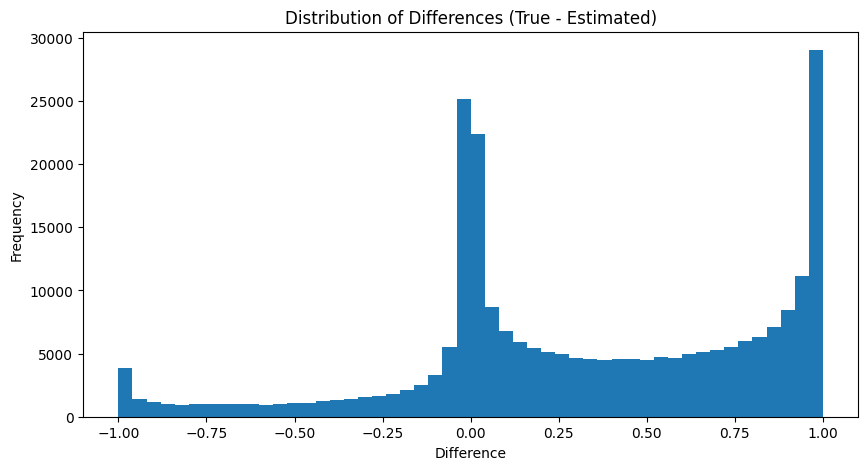

In [41]:
differences = pi_true - pi_fit
plt.figure(figsize=(10, 5))
plt.hist(differences.flatten(), bins=50)
plt.title('Distribution of Differences (True - Estimated)')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

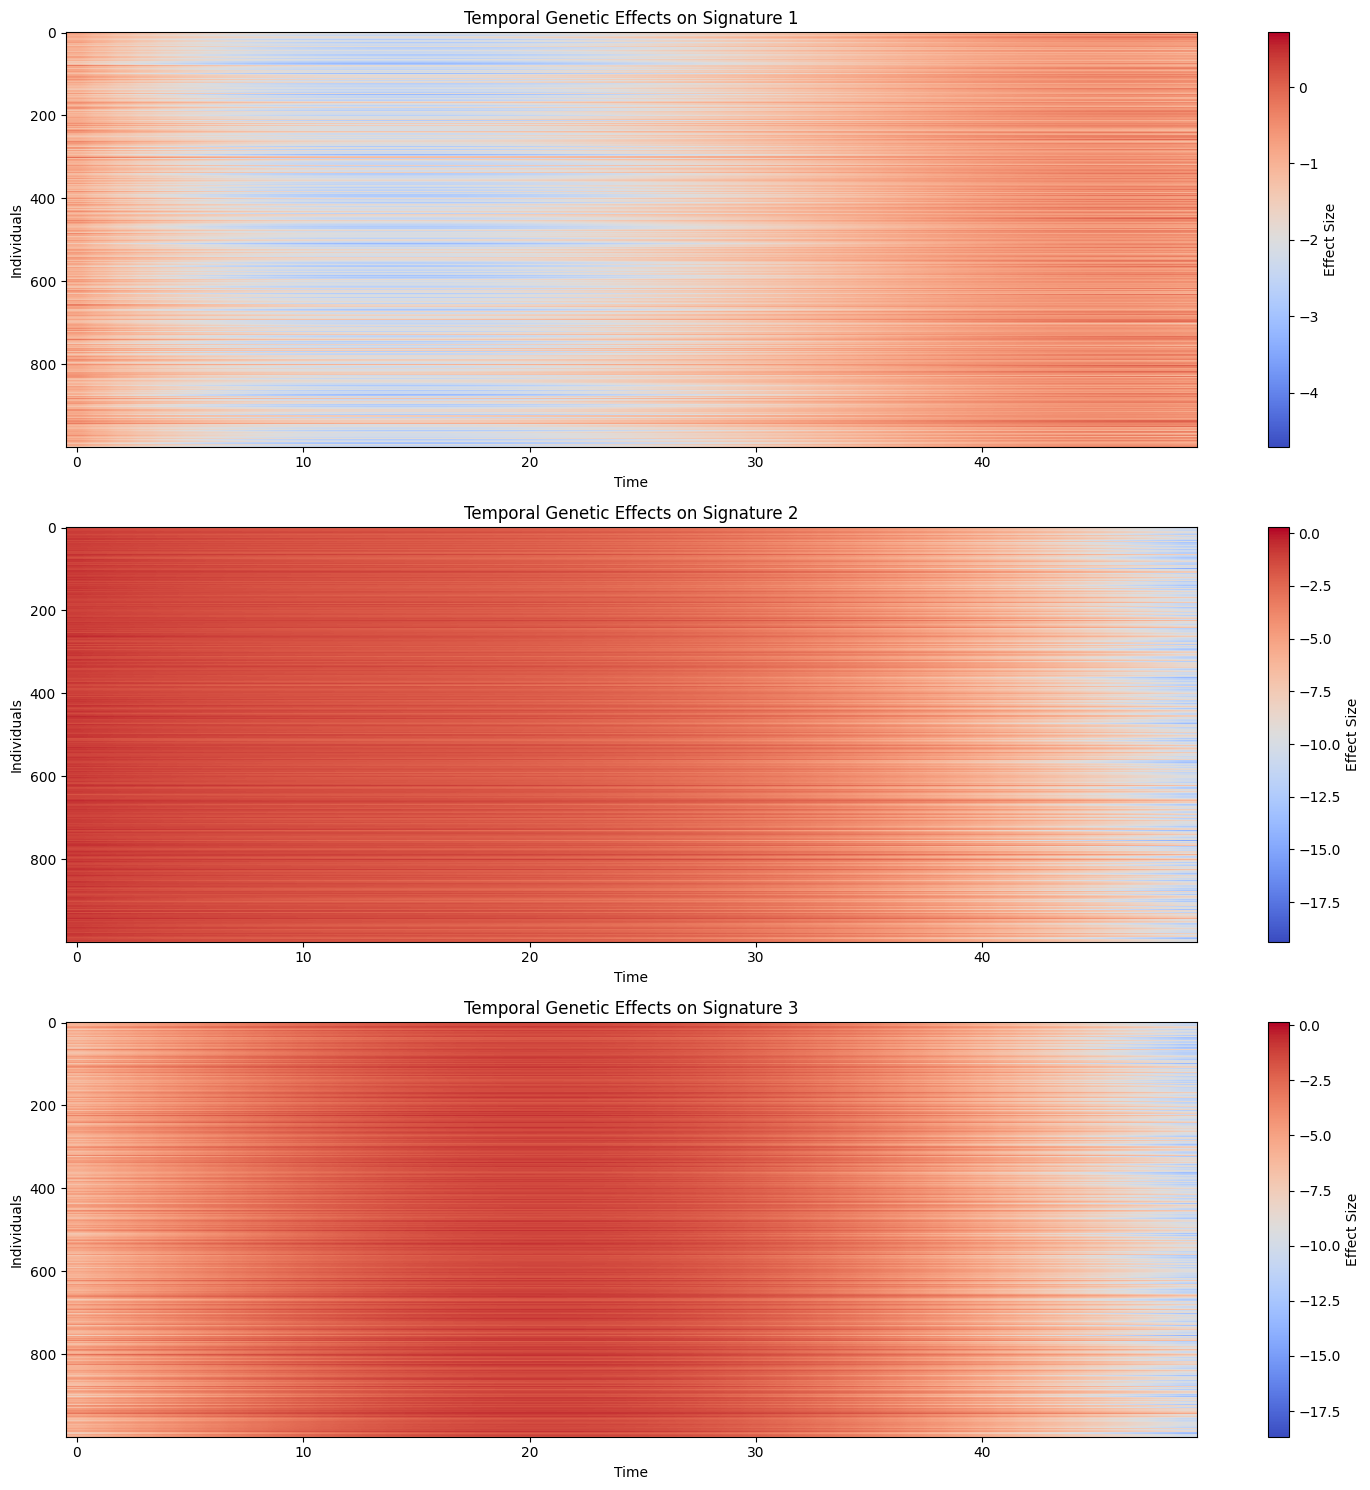

In [42]:
# Compute genetic effects on signatures
genetic_effect = np.einsum('np,pkr->nkr', model_fit.G, model_fit.B)
genetic_effect.shape
temporal_genetic_effect = np.einsum('nkr,tr->nkt', genetic_effect, model_fit.U2)

plt.figure(figsize=(15, 5 * model_fit.K))
for k in range(model_fit.K):
    plt.subplot(model_fit.K, 1, k+1)
    plt.imshow(temporal_genetic_effect[:, k, :], aspect='auto', cmap='coolwarm')
    plt.title(f'Temporal Genetic Effects on Signature {k+1}')
    plt.xlabel('Time')
    plt.ylabel('Individuals')
    plt.colorbar(label='Effect Size')

plt.tight_layout()
plt.show()

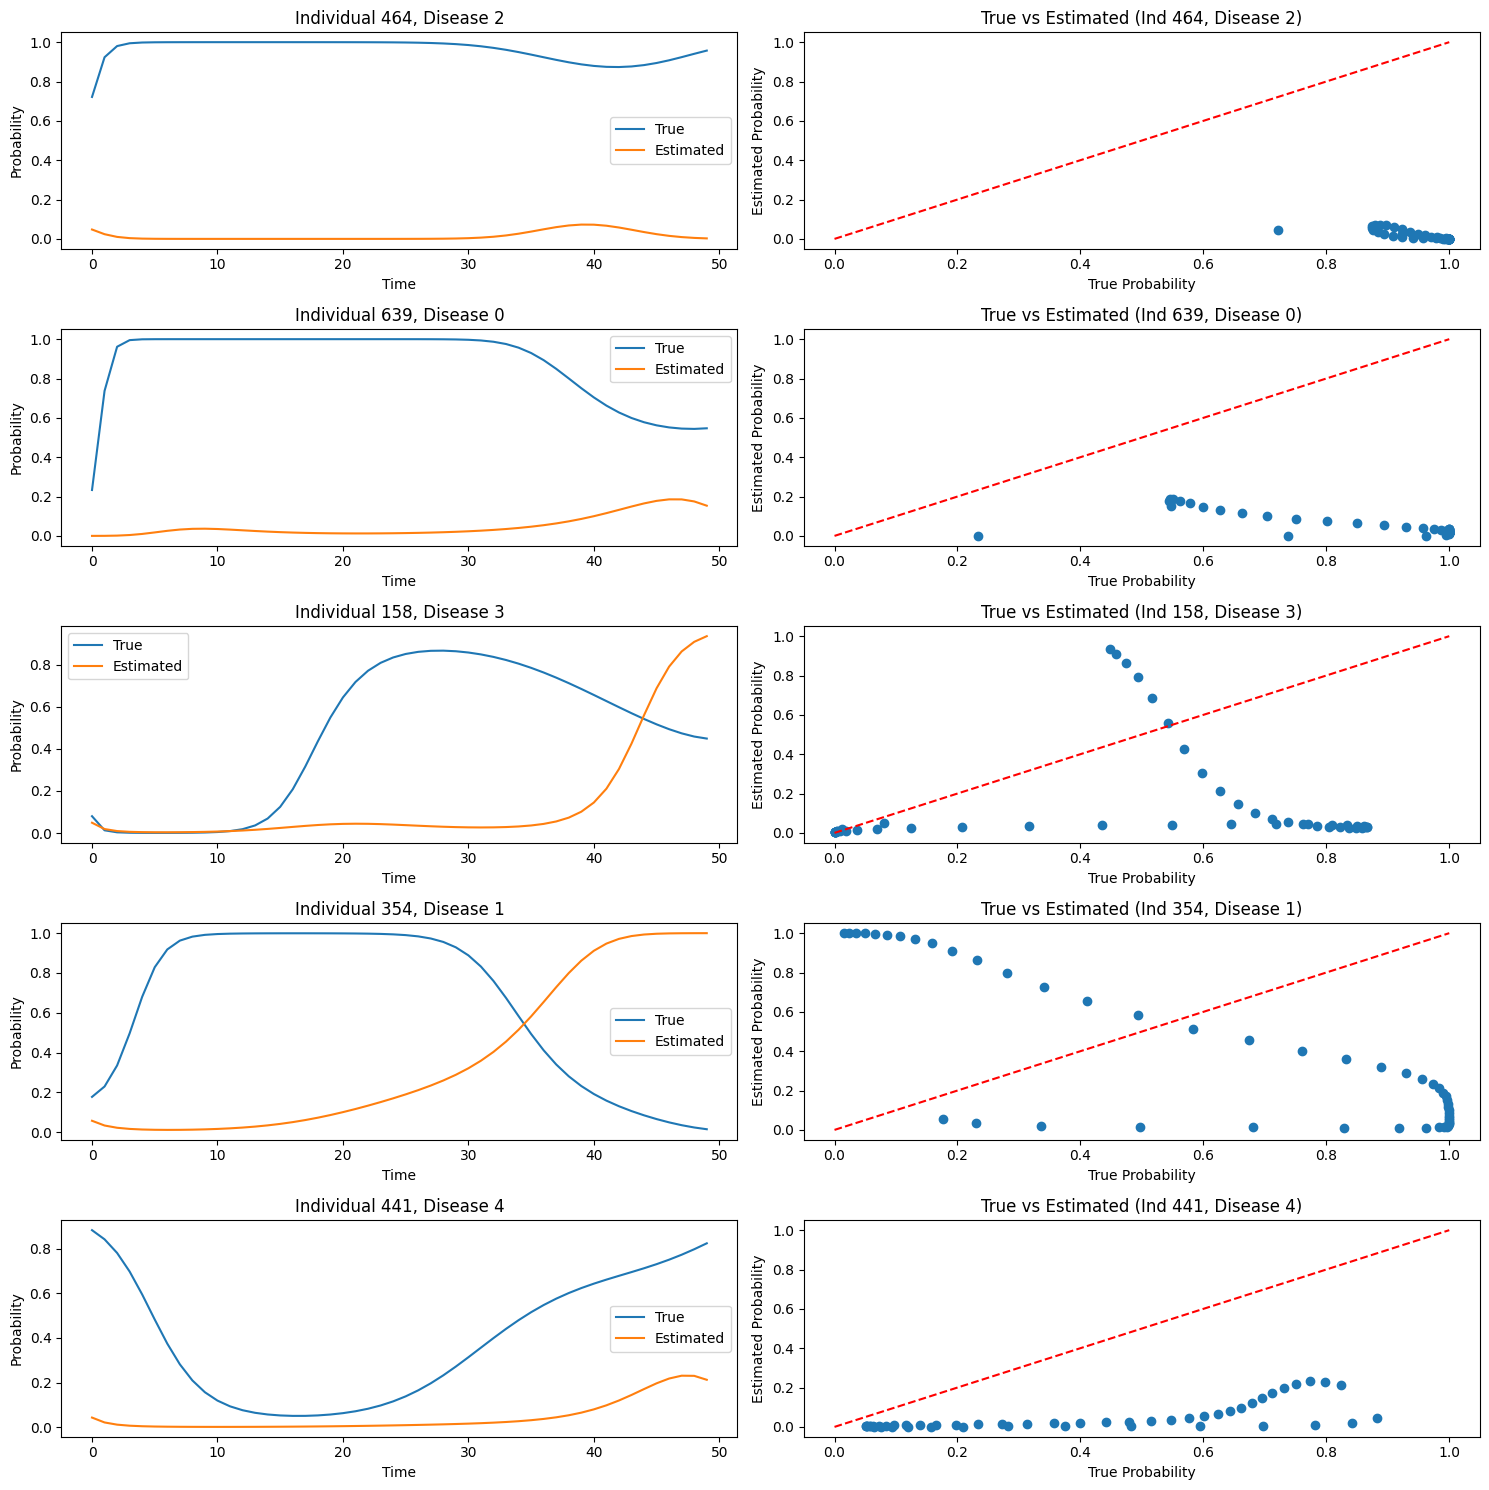

Overall correlation between true and estimated probabilities: -0.0061


In [43]:

# Plot true vs estimated pi for a few randomly selected individuals and diseases
num_samples = 5
sample_individuals = np.random.choice(N, num_samples, replace=False)
sample_diseases = np.random.choice(D, num_samples, replace=False)

plt.figure(figsize=(15, 15))
for i, (n, d) in enumerate(zip(sample_individuals, sample_diseases)):
    plt.subplot(num_samples, 2, 2*i + 1)
    plt.plot(pi_true[n, d, :], label='True')
    plt.plot(pi_fit[n, d, :], label='Estimated')
    plt.title(f'Individual {n}, Disease {d}')
    plt.xlabel('Time')
    plt.ylabel('Probability')
    plt.legend()
    
    plt.subplot(num_samples, 2, 2*i + 2)
    plt.scatter(pi_true[n, d, :], pi_fit[n, d, :])
    plt.plot([0, 1], [0, 1], 'r--')  # diagonal line
    plt.xlabel('True Probability')
    plt.ylabel('Estimated Probability')
    plt.title(f'True vs Estimated (Ind {n}, Disease {d})')

plt.tight_layout()
plt.show()

# Compute overall correlation
true_flat = pi_true.flatten()
estimated_flat = pi_fit.flatten()
correlation = np.corrcoef(true_flat, estimated_flat)[0, 1]
print(f"Overall correlation between true and estimated probabilities: {correlation:.4f}")

In [66]:
import numpy as np
from scipy.special import expit
from scipy.linalg import qr


class TensorModelWithGeneticsFixedU2U3:
    def __init__(self, N, P, D, K, R1, R2, T):
        self.N = N  # Number of individuals
        self.P = P  # Number of genetic variants
        self.D = D  # Number of diseases
        self.K = K  # Number of signatures
        self.R1 = R1  # Rank for individual patterns
        self.R2 = R2  # Rank for disease patterns
        self.T = T  # Number of time points
        self.initialized = False
        self.initialize_parameters()

    def initialize_parameters(self):
        self.U1 = np.random.randn(self.N, self.K, self.R1) * 0.01
        self.fixed_U2 = create_smooth_basis(self.T, self.R1)
        self.W = np.random.randn(self.D, self.K, self.R2) * 0.01
        self.fixed_U3 = create_smooth_basis(self.T, self.R2)
        self.G = np.random.binomial(2, 0.3, size=(self.N, self.P))
        self.B = np.random.randn(self.P, self.K, self.R1) * 0.001
        self.C = np.random.randn(self.N, self.K, self.R1) * 0.001
        self.initialized = True


    def get_dimensions(self):
        return {
            'N': self.N,
            'P': self.P,
            'D': self.D,
            'K': self.K,
            'R1': self.R1,
            'R2': self.R2,
            'T': self.T
        }

    def get_parameters(self):
        if not self.initialized:
            raise ValueError("Parameters have not been initialized yet.")
        return {
            'U1': self.U1,
            'U2': self.fixed_U2,
            'W': self.W,
            'U3': self.fixed_U3,
            'G': self.G,
            'B': self.B,
            'C': self.C
        }

    def compute_U1G(self):
        U1G = self.U1.copy()
        genetic_effect = np.einsum('np,pkr->nkr', self.G, self.B)
        U1G += genetic_effect + self.C
        return U1G

    def compute_theta(self):
        U1G = self.compute_U1G()
        lambda_k = np.einsum('nkr,tr->nkt', U1G, self.fixed_U2)
        phi = np.einsum('dkr,tr->dkt', self.W, self.fixed_U3)
        theta = np.einsum('nkt,dkt->ndt', lambda_k, phi)
        return theta

    def survival_likelihood(self, Y, S):
        theta = self.compute_theta()
        pi = expit(theta)
        log_likelihood = 0
        for n in range(self.N):
            for d in range(self.D):
                t = S[n, d]
                log_likelihood += np.sum(np.log(1 - pi[n, d, :t] + 1e-10))
                if Y[n, d, t] == 1:
                    log_likelihood += np.log(pi[n, d, t] + 1e-10)
                    pi[n, d, t+1:] = 0
        return log_likelihood

    def compute_gradients(self, Y, S):
        theta = self.compute_theta()
        pi = expit(theta)
        U1G = self.compute_U1G()
        lambda_k = np.einsum('nkr,tr->nkt', U1G, self.fixed_U2)
        phi = np.einsum('dkr,tr->dkt', self.W, self.fixed_U3)
        
        d_theta = np.zeros_like(theta)
        for n in range(self.N):
            for d in range(self.D):
                t = S[n, d]
                d_theta[n, d, :t] = -pi[n, d, :t]
                if Y[n, d, t] == 1:
                    d_theta[n, d, t] += 1
        
        d_lambda = np.einsum('ndt,dkt->nkt', d_theta, phi)
        d_phi = np.einsum('ndt,nkt->dkt', d_theta, lambda_k)
        
        d_U1G = np.einsum('nkt,tr->nkr', d_lambda, self.fixed_U2)
        d_W = np.einsum('dkt,tr->dkr', d_phi, self.fixed_U3)
        
        d_U1 = d_U1G
        d_B = np.einsum('nkr,np->pkr', d_U1G, self.G)
        d_C = d_U1G
        
        return d_U1, d_W, d_B, d_C

    def fit(self, Y, S, num_iterations=1000, learning_rate=1e-4, l2_reg=1e-5, clip_value=1.0, patience=50):
        if not self.initialized:
            raise ValueError("Parameters have not been initialized yet.")
        
        losses = []
        best_loss = -np.inf
        patience_counter = 0
        
        for iteration in range(num_iterations):
            log_likelihood = self.survival_likelihood(Y, S)
            loss = log_likelihood - l2_reg * (np.sum(self.U1**2) + np.sum(self.W**2) + np.sum(self.B**2) + np.sum(self.C**2))
            losses.append(loss)
            
            if loss > best_loss:
                best_loss = loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at iteration {iteration}")
                    break
            
            d_U1, d_W, d_B, d_C = self.compute_gradients(Y, S)
            
            d_U1 = np.clip(d_U1, -clip_value, clip_value)
            d_W = np.clip(d_W, -clip_value, clip_value)
            d_B = np.clip(d_B, -clip_value, clip_value)
            d_C = np.clip(d_C, -clip_value, clip_value)
            
            self.U1 += learning_rate * (d_U1 - 2 * l2_reg * self.U1)
            self.W += learning_rate * (d_W - 2 * l2_reg * self.W)
            self.B += learning_rate * (d_B - 2 * l2_reg * self.B)
            self.C += learning_rate * (d_C - 2 * l2_reg * self.C)
            
            if iteration % 10 == 0:
                print(f"Iteration {iteration}, Log-likelihood: {log_likelihood}")
        
        return losses

# The create_smooth_basis function remains the same
def create_smooth_basis(T, R):
    t = np.linspace(0, 1, T)
    basis = np.zeros((T, R))
    basis[:, 0] = 4 * (1 - t)**3  # early peaking
    basis[:, 1] = 27 * t * (1 - t)**2  # middle peaking
    basis[:, 2] = 4 * t**3  # late peaking
    return basis
    
    #Q, R = qr(basis, mode='economic')
    
    # Q is now an orthonormal basis
    #return Q

In [67]:
# Set up model parameters
N, P, D, K, R1, R2, T = 1000, 20, 5, 3, 3, 3, 50

# Generate synthetic data using the original model
true_model = TensorModelWithGenetics(N, P, D, K, R1, R2, T)
true_model.initialize_parameters()

theta_true = true_model.compute_theta()
pi_true = expit(theta_true)

# Generate Y and S
Y = np.zeros((N, D, T), dtype=int)
S = np.full((N, D), T - 1)

for n in range(N):
    for d in range(D):
        event_times = np.random.choice(T, size=1, p=pi_true[n, d, :] / np.sum(pi_true[n, d, :]))
        if event_times[0] < T - 1:
            Y[n, d, event_times[0]] = 1
            S[n, d] = event_times[0]

# Initialize and fit the new model with fixed U2 and U3
model_fit = TensorModelWithGeneticsFixedU2U3(N, P, D, K, R1, R2, T)
losses = model_fit.fit(Y, S, num_iterations=500, learning_rate=1e-3, l2_reg=1e-5)

# Compute fitted theta and pi
theta_fit = model_fit.compute_theta()
pi_fit = expit(theta_fit)

Iteration 0, Log-likelihood: -89374.32756782195
Iteration 10, Log-likelihood: -85220.94794599018
Iteration 20, Log-likelihood: -72080.34436407156
Iteration 30, Log-likelihood: -54392.454512145734
Iteration 40, Log-likelihood: -38218.58374294192
Iteration 50, Log-likelihood: -27534.61330729197
Iteration 60, Log-likelihood: -22707.548322930452
Iteration 70, Log-likelihood: -21461.284754718243
Iteration 80, Log-likelihood: -21104.713594774585
Iteration 90, Log-likelihood: -20756.330547056892
Iteration 100, Log-likelihood: -20355.135386564925
Iteration 110, Log-likelihood: -19930.626067220946
Iteration 120, Log-likelihood: -19534.32241186508
Iteration 130, Log-likelihood: -19187.857849812764
Iteration 140, Log-likelihood: -18899.504803060958
Iteration 150, Log-likelihood: -18670.184110695587
Iteration 160, Log-likelihood: -18488.541084799566
Iteration 170, Log-likelihood: -18355.792847566936
Iteration 180, Log-likelihood: -18238.82965346637
Iteration 190, Log-likelihood: -18116.92821225314

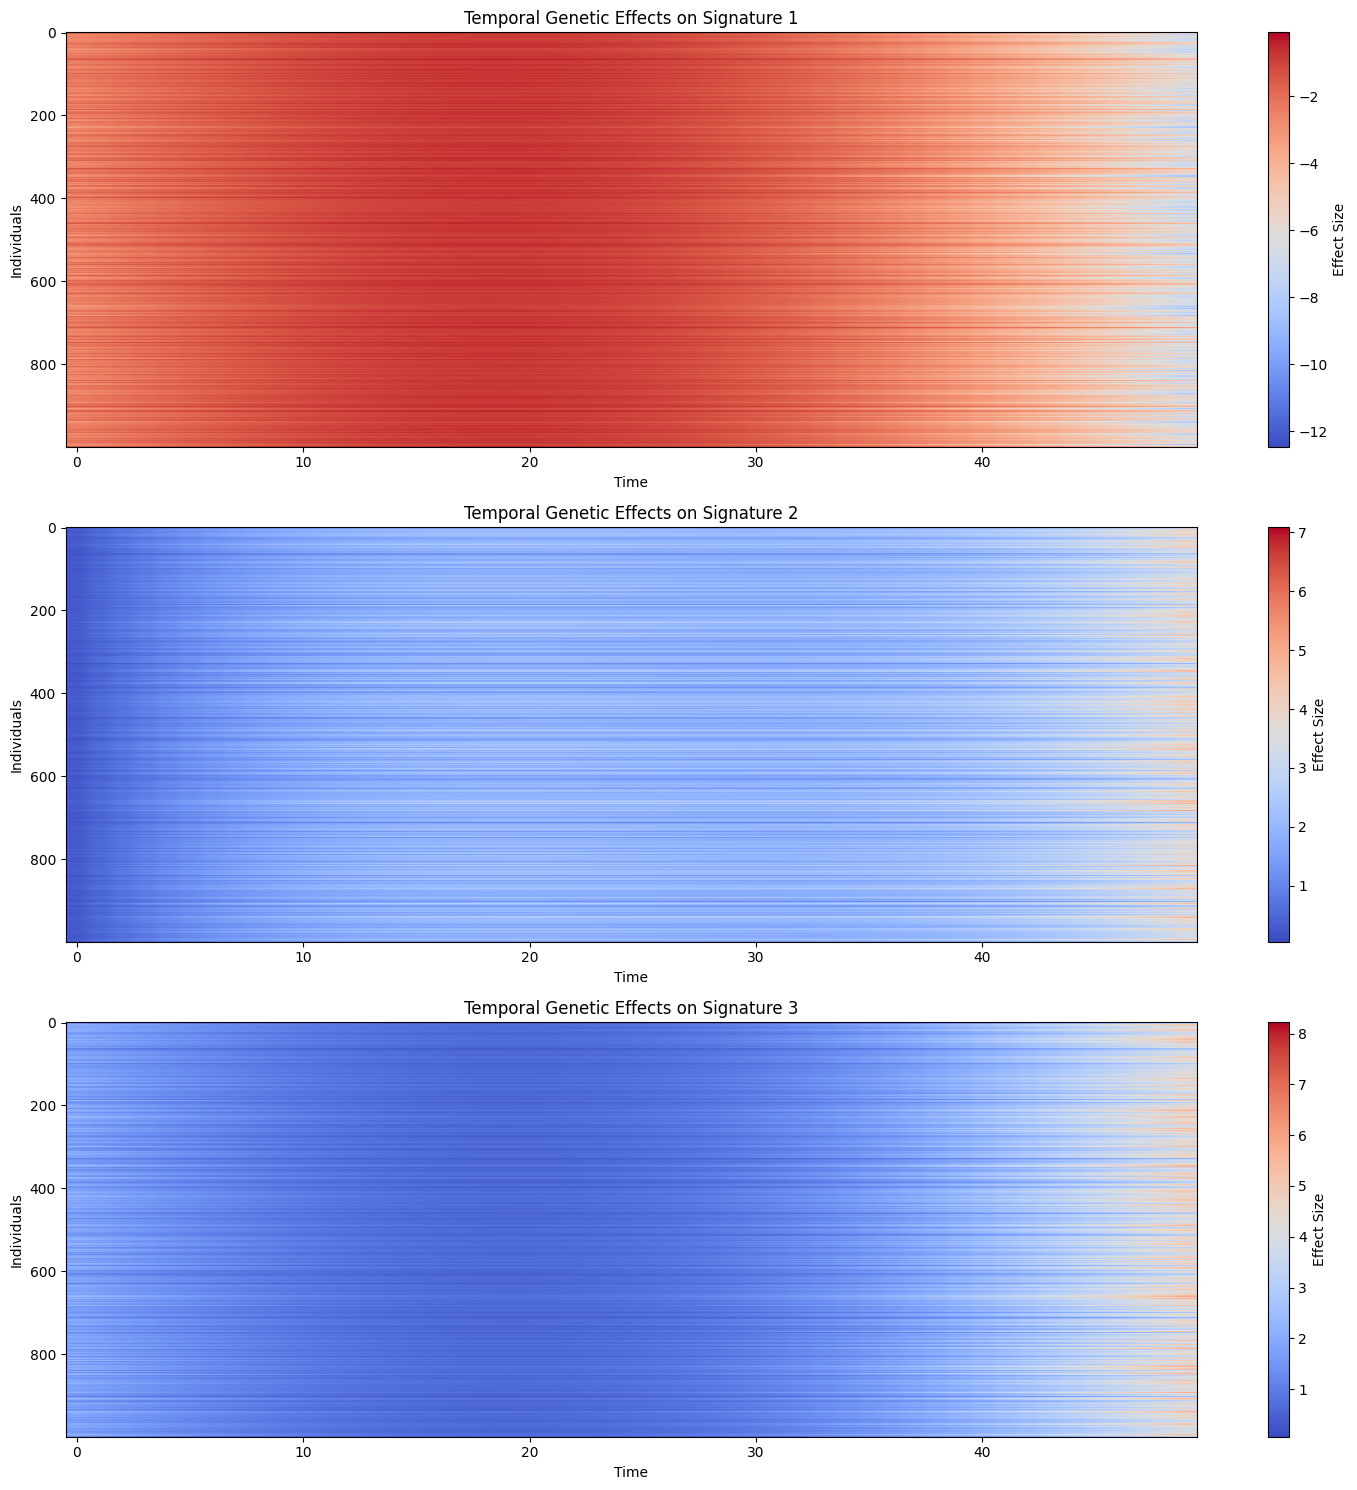

In [68]:
# Compute genetic effects on signatures
genetic_effect = np.einsum('np,pkr->nkr', model_fit.G, model_fit.B)
genetic_effect.shape
temporal_genetic_effect = np.einsum('nkr,tr->nkt', genetic_effect, model_fit.fixed_U2)

plt.figure(figsize=(15, 5 * model_fit.K))
for k in range(model_fit.K):
    plt.subplot(model_fit.K, 1, k+1)
    plt.imshow(temporal_genetic_effect[:, k, :], aspect='auto', cmap='coolwarm')
    plt.title(f'Temporal Genetic Effects on Signature {k+1}')
    plt.xlabel('Time')
    plt.ylabel('Individuals')
    plt.colorbar(label='Effect Size')

plt.tight_layout()
plt.show()

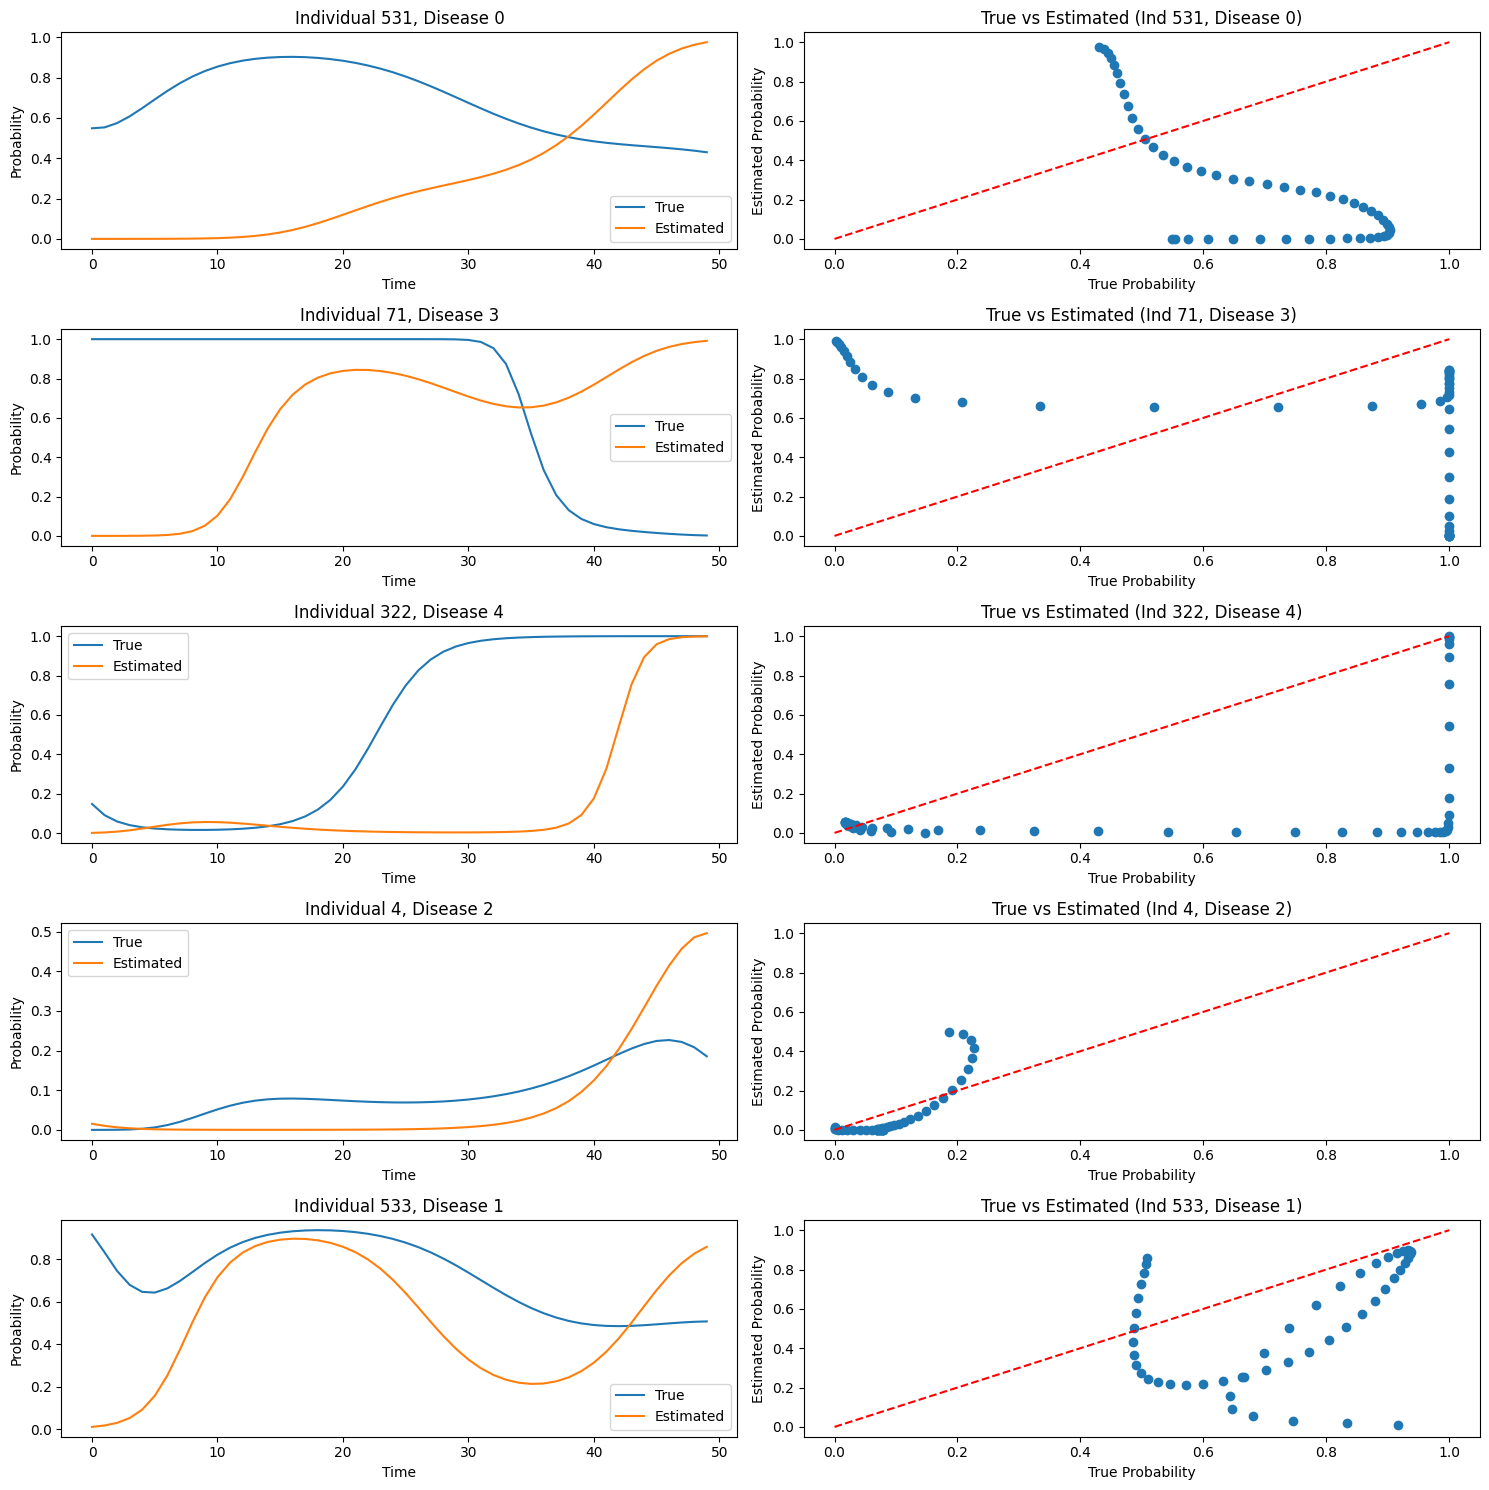

Overall correlation between true and estimated probabilities: 0.0861


In [69]:

# Plot true vs estimated pi for a few randomly selected individuals and diseases
num_samples = 5
sample_individuals = np.random.choice(N, num_samples, replace=False)
sample_diseases = np.random.choice(D, num_samples, replace=False)

plt.figure(figsize=(15, 15))
for i, (n, d) in enumerate(zip(sample_individuals, sample_diseases)):
    plt.subplot(num_samples, 2, 2*i + 1)
    plt.plot(pi_true[n, d, :], label='True')
    plt.plot(pi_fit[n, d, :], label='Estimated')
    plt.title(f'Individual {n}, Disease {d}')
    plt.xlabel('Time')
    plt.ylabel('Probability')
    plt.legend()
    
    plt.subplot(num_samples, 2, 2*i + 2)
    plt.scatter(pi_true[n, d, :], pi_fit[n, d, :])
    plt.plot([0, 1], [0, 1], 'r--')  # diagonal line
    plt.xlabel('True Probability')
    plt.ylabel('Estimated Probability')
    plt.title(f'True vs Estimated (Ind {n}, Disease {d})')

plt.tight_layout()
plt.show()

# Compute overall correlation
true_flat = pi_true.flatten()
estimated_flat = pi_fit.flatten()
correlation = np.corrcoef(true_flat, estimated_flat)[0, 1]
print(f"Overall correlation between true and estimated probabilities: {correlation:.4f}")

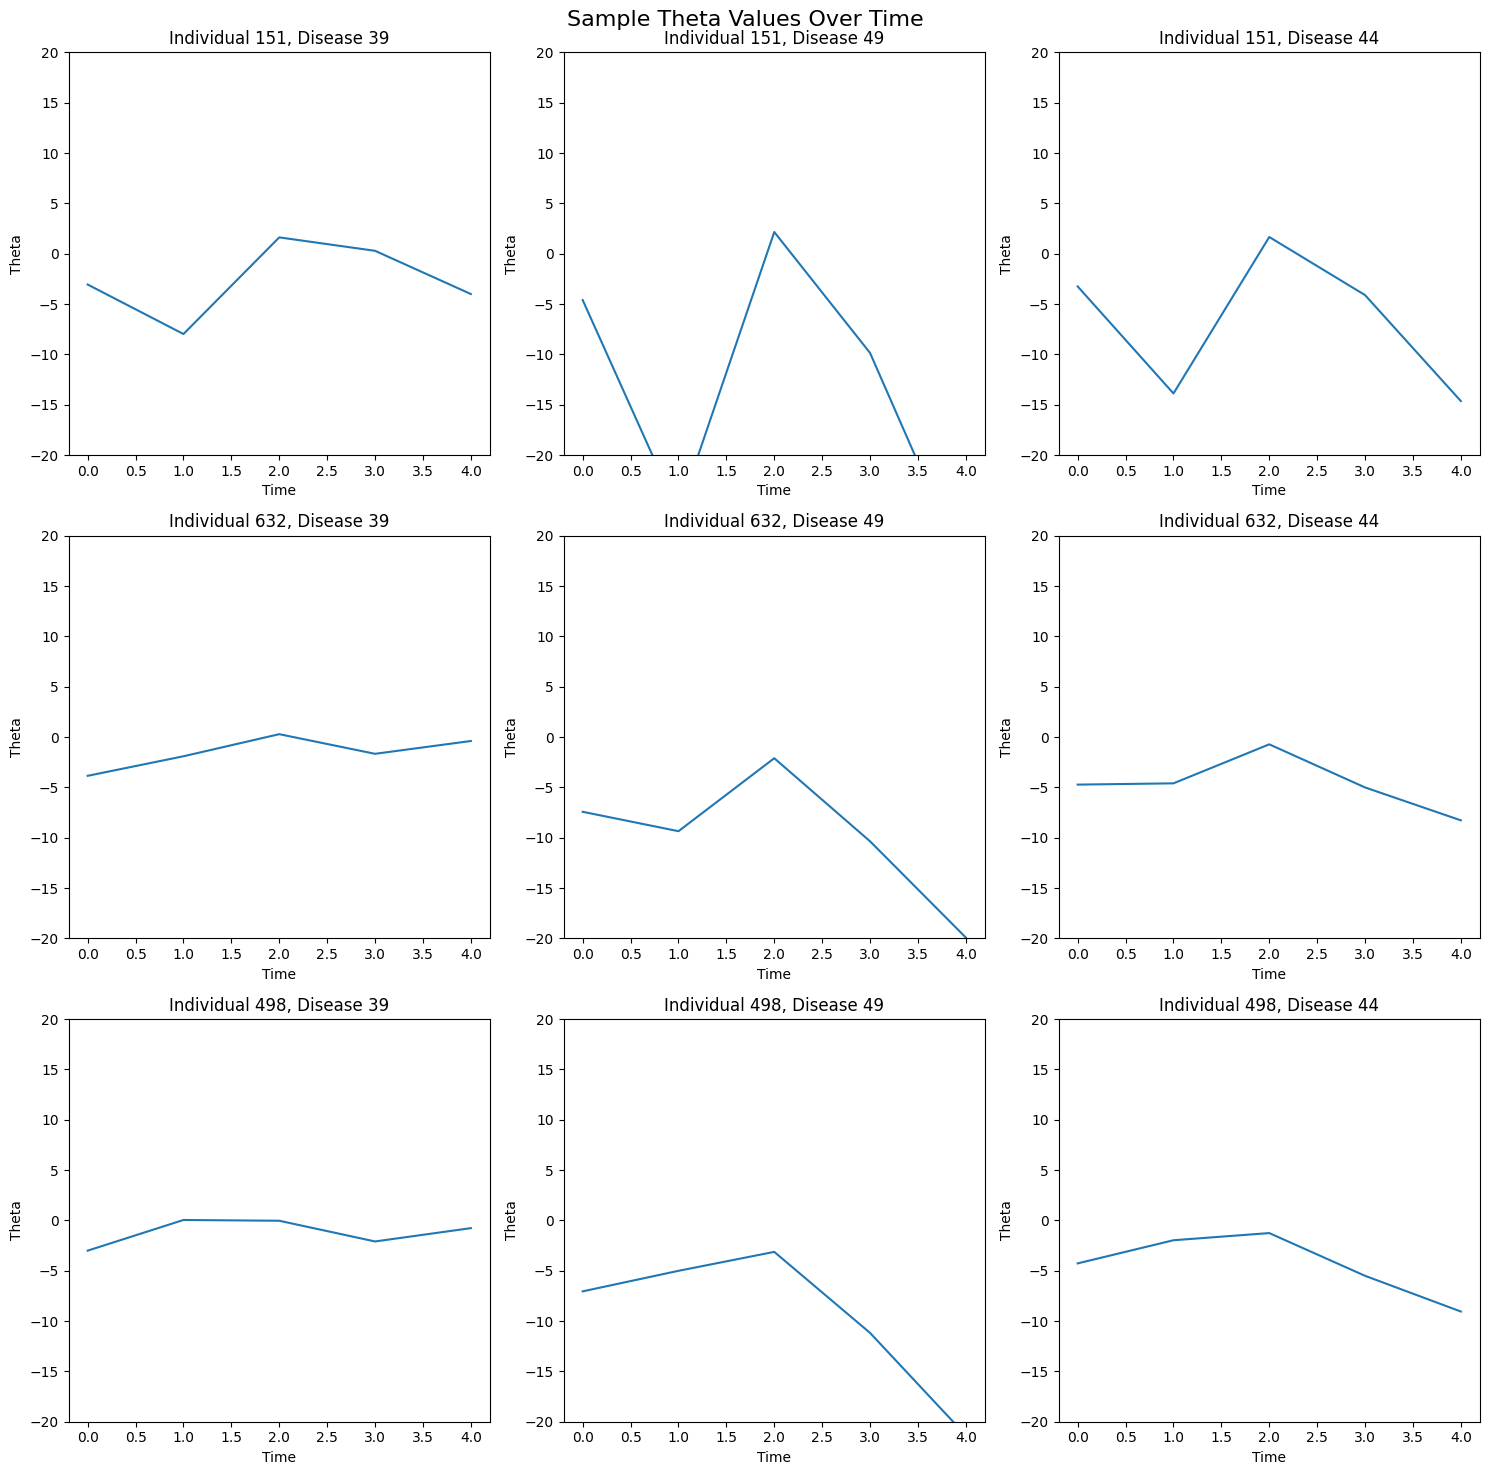

In [70]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sample_theta(theta, num_samples=3):
    N, T, D = theta.shape
    
    # Randomly select individuals and diseases
    sample_individuals = np.random.choice(N, num_samples, replace=False)
    sample_diseases = np.random.choice(D, num_samples, replace=False)
    
    # Create a grid of subplots
    fig, axs = plt.subplots(num_samples, num_samples, figsize=(15, 15))
    fig.suptitle('Sample Theta Values Over Time', fontsize=16)
    
    for i, individual in enumerate(sample_individuals):
        for j, disease in enumerate(sample_diseases):
            axs[i, j].plot(range(T), theta[individual, :, disease])
            axs[i, j].set_title(f'Individual {individual}, Disease {disease}')
            axs[i, j].set_xlabel('Time')
            axs[i, j].set_ylabel('Theta')
            axs[i, j].set_ylim(-20, 20)  # Assuming theta is a probability
    
    plt.tight_layout()
    plt.show()

# Usage:
# Assuming you have computed theta
theta = model.compute_theta()
plot_sample_theta(theta)

In [64]:
theta

array([[[-16.69911574, -17.02997217, -17.38909975, ...,  -6.03235729,
          -6.60106829,  -7.38368727],
        [ -5.85332669,  -4.71080293,  -4.15445881, ..., -10.13459196,
         -11.40269382, -12.87009307],
        [  3.41704826,   3.69655035,   3.91099006, ...,   0.14010155,
           0.12460493,   0.12878641],
        [-11.82468579, -10.1805468 ,  -8.78669061, ...,  -2.95796986,
          -3.44915686,  -3.93637479],
        [ -1.61221848,  -0.6648228 ,  -0.73344115, ...,  -0.87373214,
          -1.46963705,  -1.83442152]],

       [[-22.62094859, -20.7627458 , -18.89164173, ...,   0.28942606,
           0.4045318 ,   0.48525996],
        [ -2.02874598,  -3.00559249,  -3.84371127, ...,  -3.18352061,
          -3.67939272,  -4.18791591],
        [ -8.55019404,  -6.90780533,  -5.60567908, ...,   0.57501354,
           0.66229517,   0.7529115 ],
        [ -7.32609721,  -6.58486215,  -6.16700831, ...,  -0.76110077,
          -0.93953934,  -1.09049829],
        [  0.23721896,  -0

# let's do it without genetics

In [76]:
import numpy as np
from scipy.special import expit

def create_smooth_basis(T, R):
    t = np.linspace(0, 1, T)
    basis = np.zeros((T, R))
    basis[:, 0] = 4 * (1 - t)**3  # early peaking
    basis[:, 1] = 27 * t * (1 - t)**2  # middle peaking
    basis[:, 2] = 4 * t**3  # late peaking
    return basis

class SimplifiedTensorModelWithRanks:
    def __init__(self, N, D, K, T, R1, R2):
        self.N = N
        self.D = D
        self.K = K
        self.T = T
        self.R1 = R1
        self.R2 = R2
        self.initialize_parameters()

    def initialize_parameters(self):
        # Generate more varied data for U1 and W
        self.U1 = np.random.uniform(-1, 1, (self.N, self.K, self.R1))
        self.W = np.random.uniform(-1, 1, (self.D, self.K, self.R2))
        
        # Apply a non-linear transformation to spread out the resulting values
        self.U1 = np.tanh(self.U1)
        self.W = np.tanh(self.W)
        
        # Keep U2 and U3 as smooth basis functions
        self.U2 = create_smooth_basis(self.T, self.R1)
        self.U3 = create_smooth_basis(self.T, self.R2)

    def compute_theta(self):
        lambda_k = np.einsum('nkr,tr->nkt', self.U1, self.U2)
        phi = np.einsum('dkr,tr->dkt', self.W, self.U3)
        theta = np.einsum('nkt,dkt->ndt', lambda_k, phi)
        return theta
    
    def get_parameters(self):
        if not self.initialized:
            raise ValueError("Parameters have not been initialized yet.")
        return {
            'U1': self.U1,
            'U2': self.U2,
            'W': self.W,
            'U3': self.U3
        }

    def survival_likelihood(self, Y, S):
        theta = self.compute_theta()
        pi = expit(theta)
        log_likelihood = 0
        for n in range(self.N):
            for d in range(self.D):
                t = S[n, d]
                log_likelihood += np.sum(np.log(1 - pi[n, d, :t] + 1e-10))
                if Y[n, d, t] == 1:
                    log_likelihood += np.log(pi[n, d, t] + 1e-10)
        return log_likelihood

    def fit(self, Y, S, num_iterations=5000, learning_rate=1e-3, l2_reg=1e-5):
        for iteration in range(num_iterations):
            log_likelihood = self.survival_likelihood(Y, S)
            d_U1, d_W = self.compute_gradients(Y, S)
            
            # Apply gradient clipping
            clip_value = 1.0
            d_U1 = np.clip(d_U1, -clip_value, clip_value)
            d_W = np.clip(d_W, -clip_value, clip_value)
            
            self.U1 += learning_rate * (d_U1 - 2 * l2_reg * self.U1)
            self.W += learning_rate * (d_W - 2 * l2_reg * self.W)
            
            if iteration % 100 == 0:
                print(f"Iteration {iteration}, Log-likelihood: {log_likelihood}")
                print(f"Parameter norms: U1: {np.linalg.norm(self.U1)}, W: {np.linalg.norm(self.W)}")

        return self.compute_theta()

    def compute_gradients(self, Y, S):
        theta = self.compute_theta()
        pi = expit(theta)
        d_theta = np.zeros_like(theta)
        for n in range(self.N):
            for d in range(self.D):
                t = S[n, d]
                d_theta[n, d, :t] = -pi[n, d, :t]
                if Y[n, d, t] == 1:
                    d_theta[n, d, t] += 1
        
        lambda_k = np.einsum('nkr,tr->nkt', self.U1, self.U2)
        phi = np.einsum('dkr,tr->dkt', self.W, self.U3)
        
        d_lambda = np.einsum('ndt,dkt->nkt', d_theta, phi)
        d_phi = np.einsum('ndt,nkt->dkt', d_theta, lambda_k)
        
        d_U1 = np.einsum('nkt,tr->nkr', d_lambda, self.U2)
        d_W = np.einsum('dkt,tr->dkr', d_phi, self.U3)
        
        return d_U1, d_W

    
# Generate synthetic data with more varied probabilities
N, D, K, T, R1, R2 = 1000, 5, 3, 50, 3, 3
true_model = SimplifiedTensorModelWithRanks(N, D, K, T, R1, R2)
true_theta = true_model.compute_theta()
true_pi = expit(true_theta)

Y = np.zeros((N, D, T), dtype=int)
S = np.full((N, D), T - 1)

for n in range(N):
    for d in range(D):
        event_times = np.random.choice(T, size=1, p=true_pi[n, d, :] / np.sum(true_pi[n, d, :]))
        if event_times[0] < T - 1:
            Y[n, d, event_times[0]] = 1
            S[n, d] = event_times[0]

# Fit the model
fitted_model = SimplifiedTensorModelWithRanks(N, D, K, T, R1, R2)
fitted_theta = fitted_model.fit(Y, S)
fitted_pi = expit(fitted_theta)

# Compare true and fitted probabilities
print(f"True pi range: [{np.min(true_pi)}, {np.max(true_pi)}]")
print(f"Fitted pi range: [{np.min(fitted_pi)}, {np.max(fitted_pi)}]")
print(f"Correlation: {np.corrcoef(true_pi.flatten(), fitted_pi.flatten())[0, 1]}")


Iteration 0, Log-likelihood: -321982.4205257706
Parameter norms: U1: 46.05463010011387, W: 3.5235577703002265
Iteration 100, Log-likelihood: -197486.35085078937
Parameter norms: U1: 43.484958553914126, W: 2.9628297752786747
Iteration 200, Log-likelihood: -119213.27730564692
Parameter norms: U1: 42.46004622065766, W: 2.4736231648629383
Iteration 300, Log-likelihood: -71689.69745554976
Parameter norms: U1: 42.927221835951386, W: 2.0811819852033406
Iteration 400, Log-likelihood: -43530.18782003262
Parameter norms: U1: 44.02002096175453, W: 1.8734315878022567
Iteration 500, Log-likelihood: -28204.021490790008
Parameter norms: U1: 44.379731354031236, W: 1.787406840230564
Iteration 600, Log-likelihood: -21471.568436339003
Parameter norms: U1: 44.42185040123361, W: 1.78141198650165
Iteration 700, Log-likelihood: -18780.39063777304
Parameter norms: U1: 44.84050850354618, W: 1.927307536036914
Iteration 800, Log-likelihood: -17387.7617313701
Parameter norms: U1: 45.80035111108517, W: 2.226955782

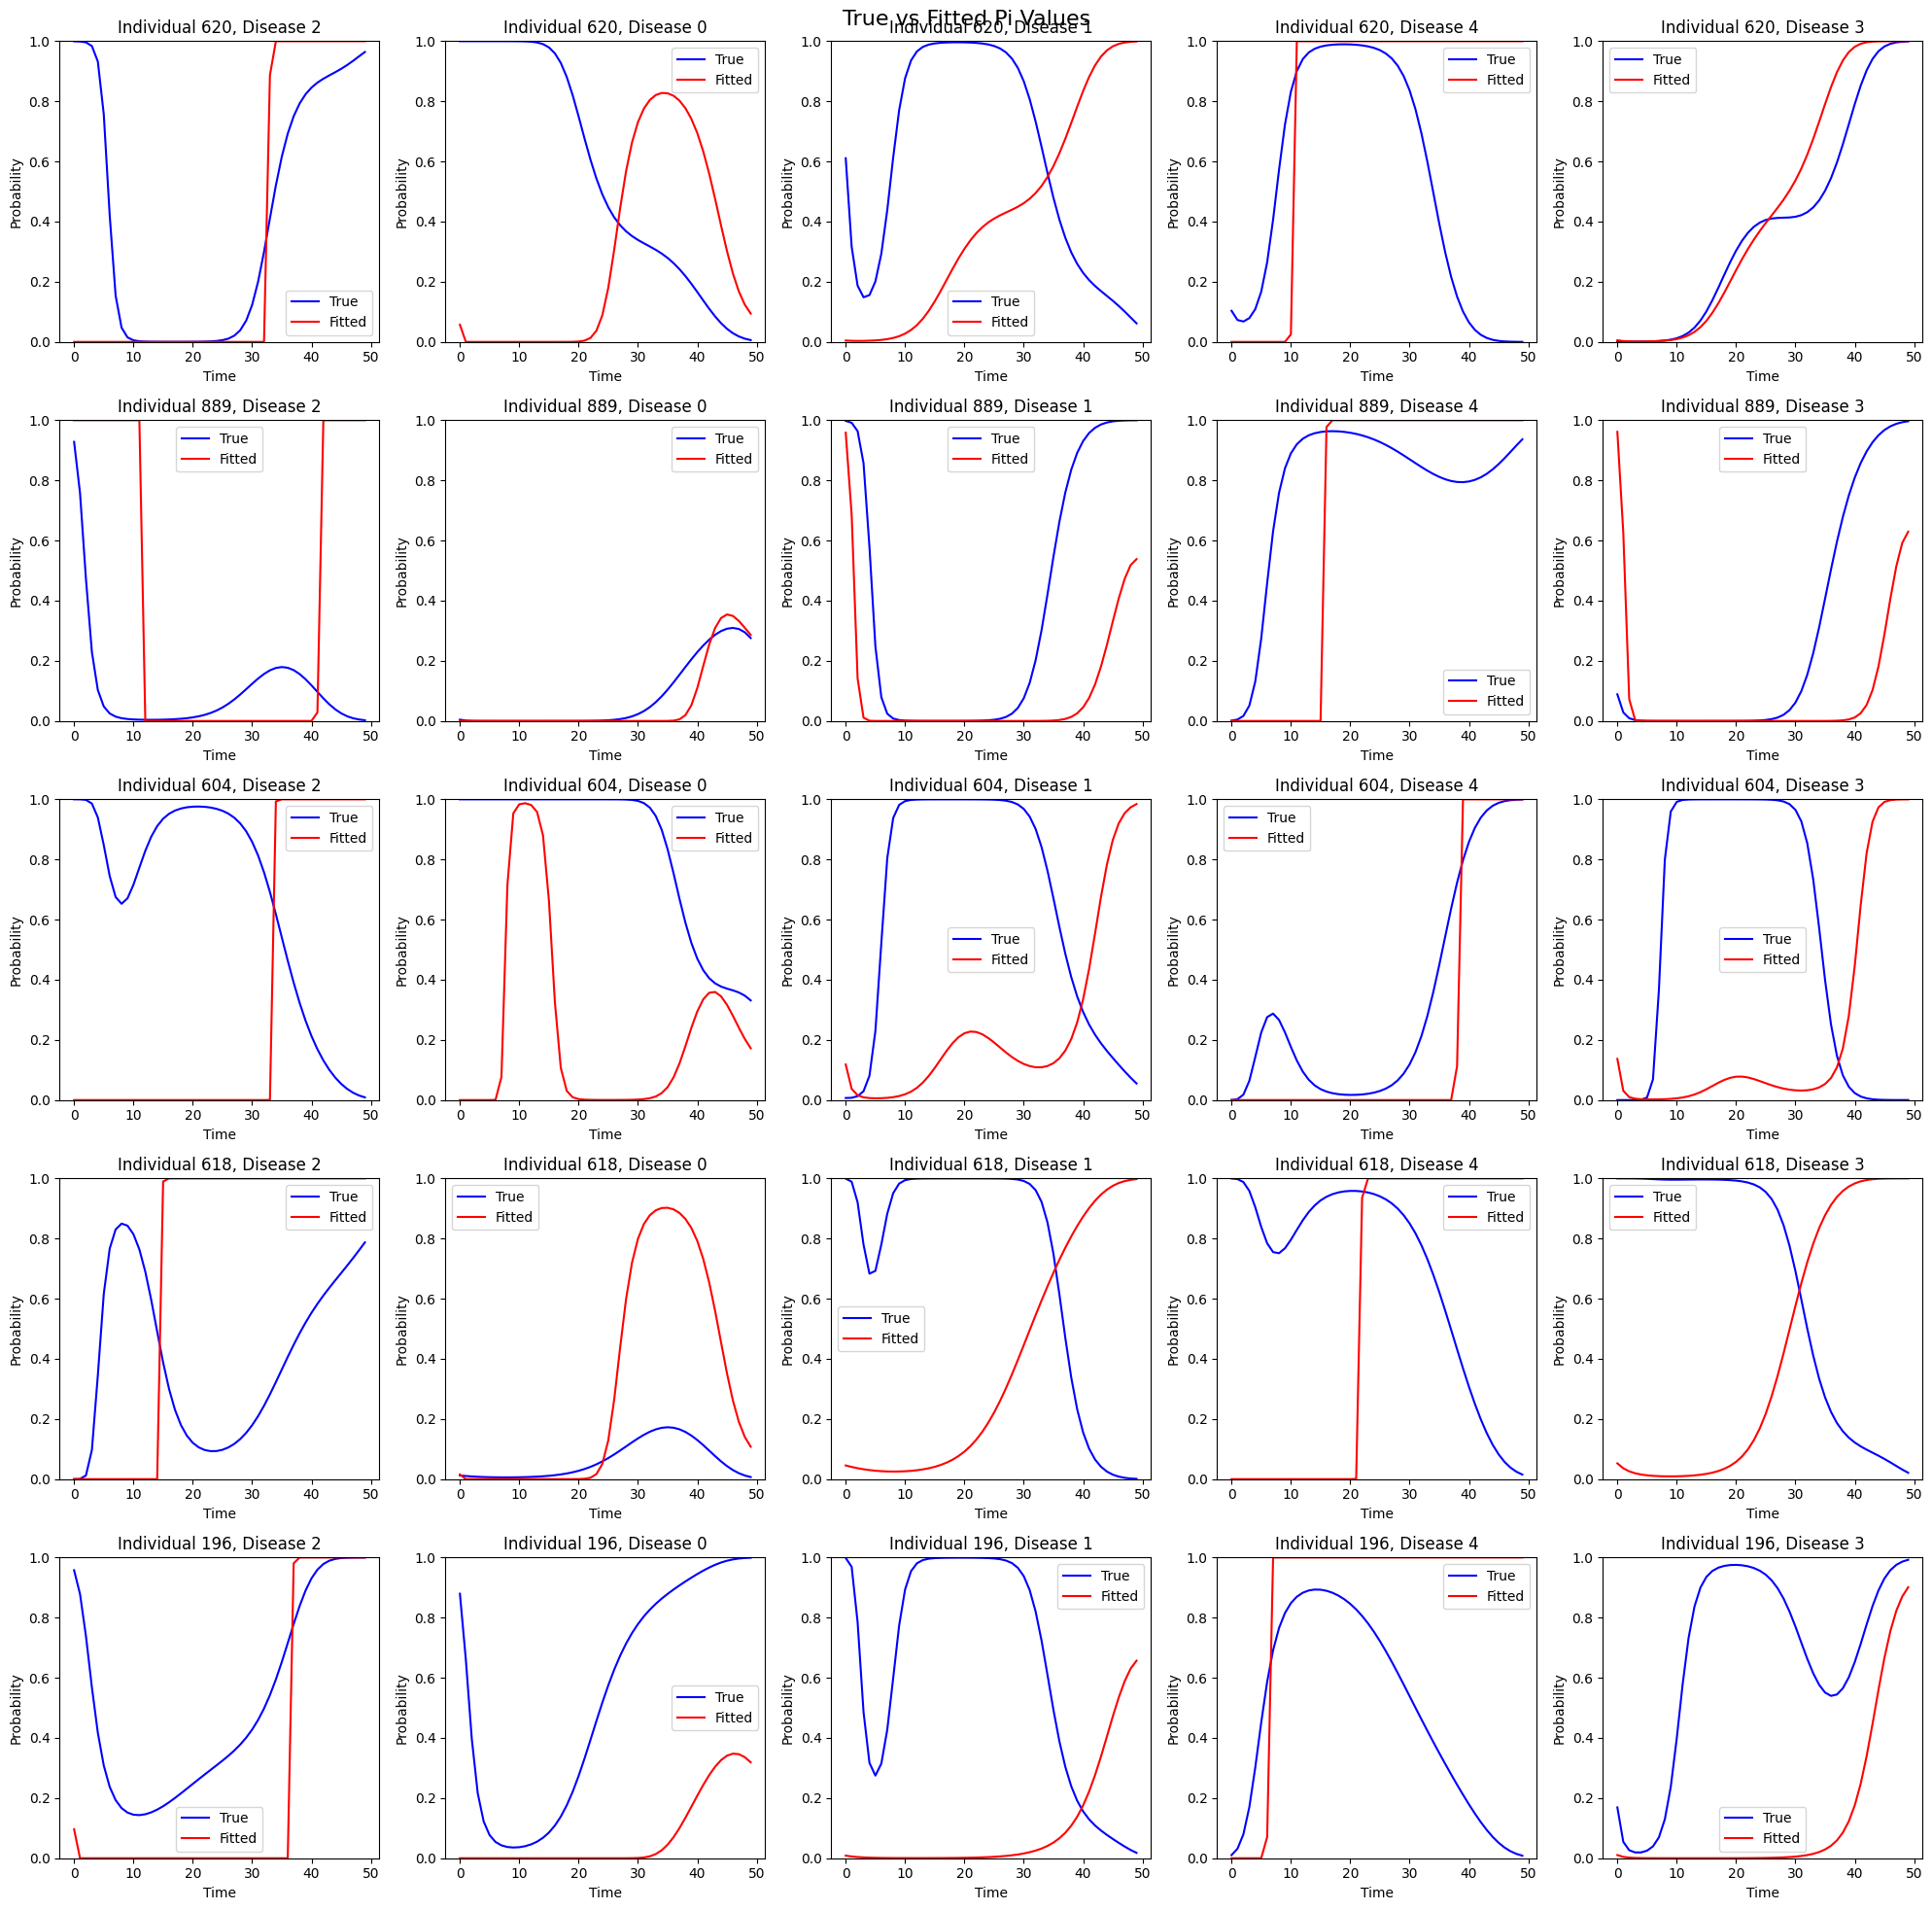

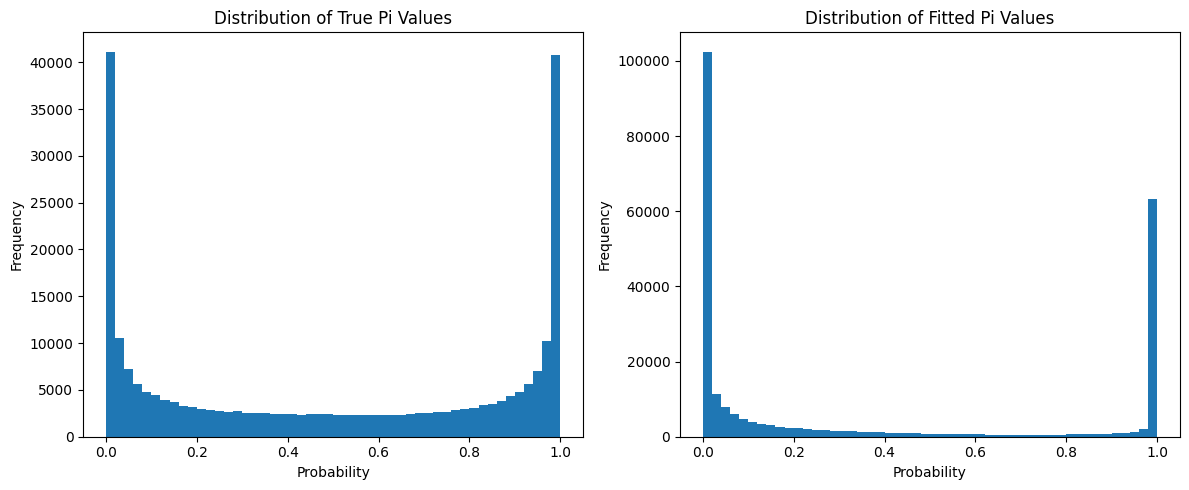

In [77]:
import matplotlib.pyplot as plt
import numpy as np

def plot_pis(true_pi, fitted_pi, num_samples=5):
    N, D, T = true_pi.shape
    
    # Randomly select individuals and diseases
    sample_individuals = np.random.choice(N, num_samples, replace=False)
    sample_diseases = np.random.choice(D, num_samples, replace=False)
    
    fig, axs = plt.subplots(num_samples, num_samples, figsize=(20, 20))
    fig.suptitle('True vs Fitted Pi Values', fontsize=16)
    
    for i, individual in enumerate(sample_individuals):
        for j, disease in enumerate(sample_diseases):
            axs[i, j].plot(range(T), true_pi[individual, disease, :], label='True', color='blue')
            axs[i, j].plot(range(T), fitted_pi[individual, disease, :], label='Fitted', color='red')
            axs[i, j].set_title(f'Individual {individual}, Disease {disease}')
            axs[i, j].set_xlabel('Time')
            axs[i, j].set_ylabel('Probability')
            axs[i, j].legend()
            axs[i, j].set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

# Assuming you have true_pi and fitted_pi from your previous run
plot_pis(true_pi, fitted_pi)

# Also, let's plot histograms of the true and fitted pi values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(true_pi.flatten(), bins=50, range=(0, 1))
plt.title('Distribution of True Pi Values')
plt.xlabel('Probability')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(fitted_pi.flatten(), bins=50, range=(0, 1))
plt.title('Distribution of Fitted Pi Values')
plt.xlabel('Probability')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()